<center>
<img
src="https://i.ibb.co/th5MTcv/logo.png" width="800" 
     />
</center>

## Orbit equation for a particle under Newtonian gravity.

The differential equation for the orbit of a particle moving under Newtonian gravity is obtained from the Lagrangian describing the system. This equation relates the radial coordinate $r$ with the angular coordinate $\phi$ in the orbital plane. Usually, the differential equation is written in terms of the auxiliary variable $u=\frac{1}{r}$ as

\begin{equation}
\frac{d^2 u}{d\varphi^2} = - u +\frac{GM}{\ell^2}
\end{equation}

where we have identified the conserved orbital angular momentum : $\ell = p_\phi$.

An important consideration has to do with the magnitudes of the physical quantities and constants involved in the problem. For the development, we will use the following system of units:

- Units of mass: Solar Masses $M_{\odot}$
- Distance units: astronomical units [au]
- Time units: years [yr]

In this system of units, the Newtonian gravitational constant takes the value $G = 4\pi^2$.

## Deep Neural Netwok

Our first attempt to describe the motion of the test particle under a Newtonian gravitational force will be a deep neural network that we will train using known data of the trajectory. We will load the data of the orbit from the file ``'Newtonian_orbit.txt'`` and choose 10 points as the training set.

In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Total available data :  (100000, 2)
Training points:   phi: torch.Size([10, 1])  u: torch.Size([10, 1])


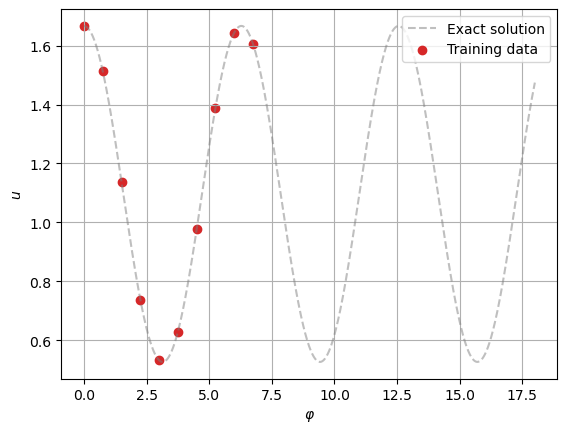

In [2]:
y = np.loadtxt('Newtonian_orbit.txt')
print('Total available data : ',y.shape)
phi = torch.from_numpy(y[:60000:10,0]).view(-1,1).to(torch.float32)
u = torch.from_numpy(y[:60000:10,1]).view(-1,1).to(torch.float32)

# slice out a small number of points (10) from the domain
phi_data = phi[0:2500:250]
u_data = u[0:2500:250]
print('Training points: ',' phi:', phi_data.shape, ' u:', u_data.shape)

# Plot of the exact solution
plt.figure()
plt.plot(phi, u, color='gray', alpha=0.5, linestyle='--' , label="Exact solution")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


### Training the Deep Neural Network using only data from the known solution.

We use a class to define the deep neural network structure and we also introduce here two functions to plot and animate the training process.

In [3]:
class DNN(nn.Module):
    """
    Defines a connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        #self.dropout = nn.Dropout(p=0.3)
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Saves GIF file from image files"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    #plt.scatter(x0, y0, s=60, color="tab:red", alpha=0.4, label='Initial Condition')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 30)
    plt.ylim(0, 2)
    plt.text(30.,0.3,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

Now, we will train the deep neural network using the known points along the trajectory. Note that we use a neural network with 3 layers with 32 units each, an ADAM optimizer and the MSE as the loss function.

Epoch:  100  Loss:  0.07300273329019547
Epoch:  200  Loss:  0.010976595804095268
Epoch:  300  Loss:  0.0059803021140396595
Epoch:  400  Loss:  0.004841783083975315
Epoch:  500  Loss:  0.004059764556586742
Epoch:  600  Loss:  0.0034881874453276396
Epoch:  700  Loss:  0.003057196270674467
Epoch:  800  Loss:  0.0027184344362467527
Epoch:  900  Loss:  0.002430866938084364
Epoch:  1000  Loss:  0.0021572166588157415


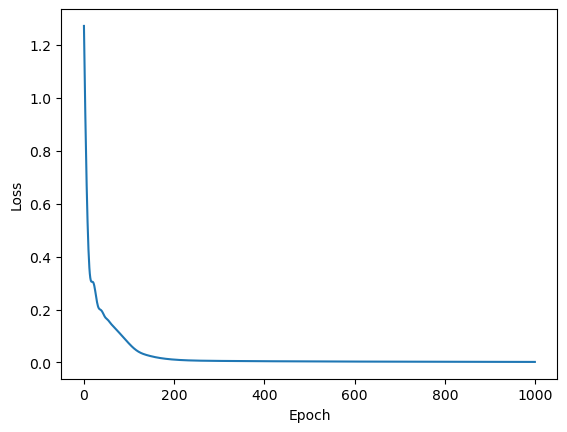

In [4]:

# Train the standard neural network to fit the training data

epochs = 1000

torch.manual_seed(413)
model = DNN(1,1,32,3) # 1 input, 1 output, 32 neurons in 3 hidden layers
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []

for i in range(1000):
    optimizer.zero_grad()
    u_pred = model(phi_data)
    loss = torch.mean((u_pred-u_data)**2) # mean squared error
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # Save plots of the training
    if (i+1) % 10 == 0:
        u_pred = model(phi).detach()
        plot_result(phi,u,phi_data,u_data,u_pred)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()

        #if (i+1) % 500 == 0: plt.show()
        #else: plt.close("all")

    if (i+1) %100 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("nn.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using data from the differential equation, the initial condition and some known data from the exact solution.

We will define a PINN usinf the samen class defined above but considering the loss function as the weighted sum of three contributions:

`loss1` : MSE of known data  $\mathcal{L}_1 = \sum _i (u^p_i - u_i)^2$

`loss2` : MSE of the initial condition  $\mathcal{L}_2 = \sum _i (u^p_0 - u_0)^2$

`loss3` : differential equation  $\mathcal{L}_3 = \frac{d^2 u}{d\varphi^2}  + u -\frac{GM}{\ell^2}$

The total loss is 

\begin{equation}
\mathcal{L} = w_1 \mathcal{L}_1 + w_2 \mathcal{L}_2 + w_3 \mathcal{L}_3
\end{equation}

We chose the weights $w_1 = w_2 = 1$ and $w_3 = 10^{-2}$

Epoch:  500  Loss:  0.0075271157547831535
Epoch:  1000  Loss:  0.004282596055418253
Epoch:  1500  Loss:  0.002533263061195612
Epoch:  2000  Loss:  0.0004992702160961926
Epoch:  2500  Loss:  0.00023103036801330745
Epoch:  3000  Loss:  0.0001770353119354695
Epoch:  3500  Loss:  0.00016382255125790834
Epoch:  4000  Loss:  0.00016802511527203023
Epoch:  4500  Loss:  0.00013829504314344376
Epoch:  5000  Loss:  0.00013486180978361517
Epoch:  5500  Loss:  0.0001318161957897246
Epoch:  6000  Loss:  0.00012936365965288132
Epoch:  6500  Loss:  0.00012725083797704428
Epoch:  7000  Loss:  0.0001309169310843572
Epoch:  7500  Loss:  0.00012350147881079465
Epoch:  8000  Loss:  0.00012192021677037701
Epoch:  8500  Loss:  0.00012032892846036702
Epoch:  9000  Loss:  0.00011863829422509298
Epoch:  9500  Loss:  0.00011693218402797356
Epoch:  10000  Loss:  0.00015476960106752813
Epoch:  10500  Loss:  0.0002840678789652884
Epoch:  11000  Loss:  0.00010931530414381996
Epoch:  11500  Loss:  0.0004994570626877

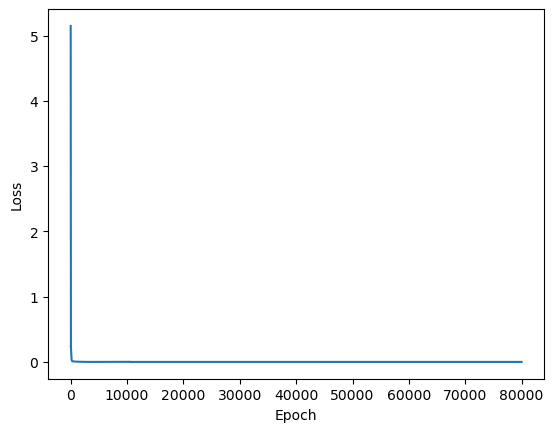

In [6]:
def ODE(model, x):
    """
    ODE of the orbit in Newtonian gravity.
    """

    y = model(x)
    # computes dy/dx
    dydx  = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    # computes d^2y/dx^2
    dydx2 = torch.autograd.grad(dydx,  x, torch.ones_like(dydx),  create_graph=True)[0]
    # computes the differential equation
    ode = dydx2 + y - G*M/L**2
    return ode



# Sample locations over the problem domain
phi_physics = torch.linspace(0,18,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
G = 4*np.pi**2
M = 1
L = 6


epochs = 80000
torch.manual_seed(413)
model = DNN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel = model
bestLoss = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data)
    loss1 = torch.mean((u_pred[1:] - u_data[1:])**2)# use mean squared error

    # compute the "initial data loss"
    u_pred = model(phi_data)
    loss2 = torch.mean((u_pred[0] - u_data[0])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss3 = torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2 + (1e-2)*loss3

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data,u_data,u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

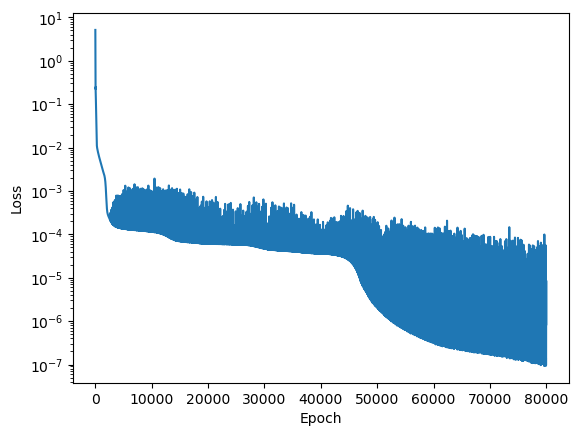

In [11]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

Best loss:  9.27847452203423e-08


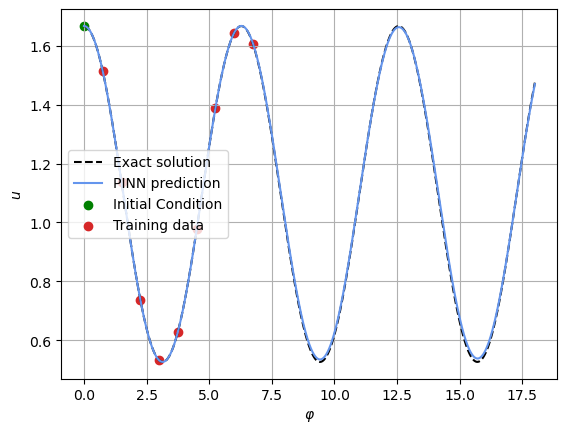

In [9]:
print('Best loss: ', bestLoss)

# Plot the final result
u_pred = bestModel(phi).detach()
plt.figure()
plt.plot(phi, u, 'k--', label="Exact solution")
plt.plot(phi, u_pred, color='cornflowerblue', label="PINN prediction")
plt.scatter(phi_data[0], u_data[0], color="green", label="Initial Condition")
plt.scatter(phi_data[1:], u_data[1:], color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


### Definition of the PINN and training using data from the differential equation and less data.



Now we will define a PINN usinf the samen class defined above but considering the loss function as the weighted sum of three contributions:

`loss1` : MSE of known data  $\mathcal{L}_1 = \sum _i (u^p_i - u_i)^2$

`loss2` : MSE of the initial condition  $\mathcal{L}_2 = \sum _i (u^p_0 - u_0)^2$

`loss3` : differential equation  $\mathcal{L}_3 = \frac{d^2 u}{d\varphi^2} = - u +\frac{GM}{\ell^2}$

The total loss is 

\begin{equation}
\mathcal{L} = w_1 \mathcal{L}_1 + w_2 \mathcal{L}_2 + w_3 \mathcal{L}_3
\end{equation}

Epoch:  500  Loss:  0.0032829693518579006
Epoch:  1000  Loss:  0.0021555102430284023
Epoch:  1500  Loss:  0.0013588471338152885
Epoch:  2000  Loss:  0.001176277408376336
Epoch:  2500  Loss:  0.001076594926416874
Epoch:  3000  Loss:  0.0010201426921412349
Epoch:  3500  Loss:  0.0009845688473433256
Epoch:  4000  Loss:  0.0009603337966836989
Epoch:  4500  Loss:  0.0009423947776667774
Epoch:  5000  Loss:  0.0009280903032049537
Epoch:  5500  Loss:  0.0009168512187898159
Epoch:  6000  Loss:  0.0009078859002329409
Epoch:  6500  Loss:  0.0013792796526104212
Epoch:  7000  Loss:  0.0008885216084308922
Epoch:  7500  Loss:  0.0008816515328362584
Epoch:  8000  Loss:  0.0008801540243439376
Epoch:  8500  Loss:  0.0008663033368065953
Epoch:  9000  Loss:  0.0008606568444520235
Epoch:  9500  Loss:  0.0008557282271794975
Epoch:  10000  Loss:  0.0009307654690928757
Epoch:  10500  Loss:  0.0008440756937488914
Epoch:  11000  Loss:  0.002229271922260523
Epoch:  11500  Loss:  0.0008350813295692205
Epoch:  120

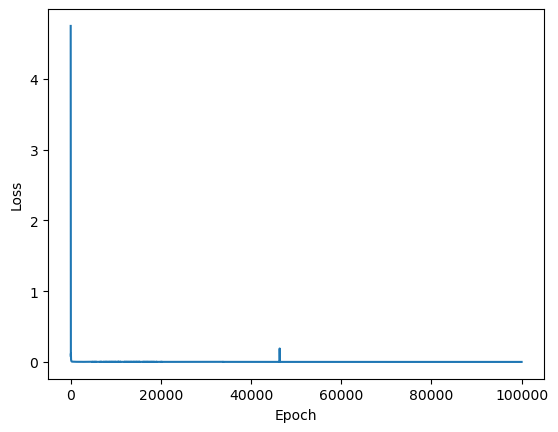

In [16]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,18,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
G = 4*np.pi**2
M=1
L=6


epochs = 100000
torch.manual_seed(413)
model = DNN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel2 = model
bestLoss2 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data)
    loss1 = torch.mean((u_pred[1:6] - u_data[1:6])**2)# use mean squared error

    # compute the "initial data loss"
    u_pred = model(phi_data)
    loss2 = torch.mean((u_pred[0] - u_data[0])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss3 = torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2 + (1e-1)*loss3

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss2:
        bestLoss2 = loss.item()
        bestModel2 = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data[:6],u_data[:6],u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

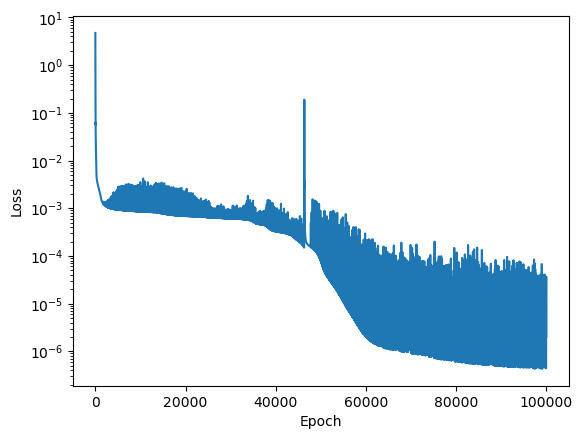

In [17]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

Best loss:  4.2673315192587324e-07


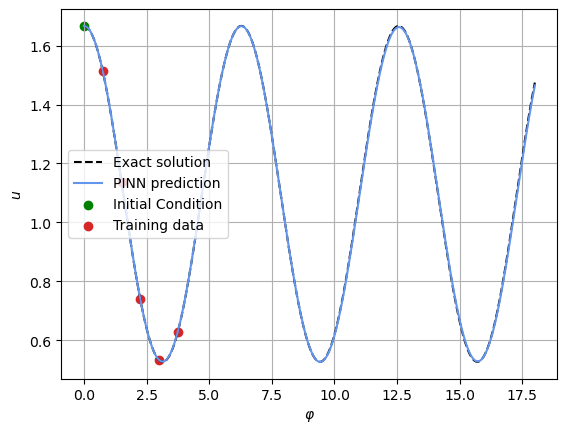

In [18]:
print('Best loss: ', bestLoss2)

# Plot the final result
u_pred = bestModel2(phi).detach()
plt.figure()
plt.plot(phi, u, 'k--', label="Exact solution")
plt.plot(phi, u_pred, color='cornflowerblue', label="PINN prediction")
plt.scatter(phi_data[0], u_data[0], color="green", label="Initial Condition")
plt.scatter(phi_data[1:6], u_data[1:6], color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


### Definition of the PINN and training using data from the differential equation and the initial condition.

Epoch:  500  Loss:  0.001042501418851316
Epoch:  1000  Loss:  0.0008493190398439765
Epoch:  1500  Loss:  0.0007762087625451386
Epoch:  2000  Loss:  0.0007247535977512598
Epoch:  2500  Loss:  0.0006824645097367465
Epoch:  3000  Loss:  0.000649808207526803
Epoch:  3500  Loss:  0.0006229206337593496
Epoch:  4000  Loss:  0.0005995059618726373
Epoch:  4500  Loss:  0.0005773199372924864
Epoch:  5000  Loss:  0.0005543914739973843
Epoch:  5500  Loss:  0.0005310224369168282
Epoch:  6000  Loss:  0.0005134365055710077
Epoch:  6500  Loss:  0.0005015461356379092
Epoch:  7000  Loss:  0.0004979159566573799
Epoch:  7500  Loss:  0.00048314910964109004
Epoch:  8000  Loss:  0.0004741273878607899
Epoch:  8500  Loss:  0.00046400356222875416
Epoch:  9000  Loss:  0.0004568199219647795
Epoch:  9500  Loss:  0.00045050005428493023
Epoch:  10000  Loss:  0.00044165991130284965
Epoch:  10500  Loss:  0.00043046814971603453
Epoch:  11000  Loss:  0.0004234388470649719
Epoch:  11500  Loss:  0.000416271184803918
Epoch:

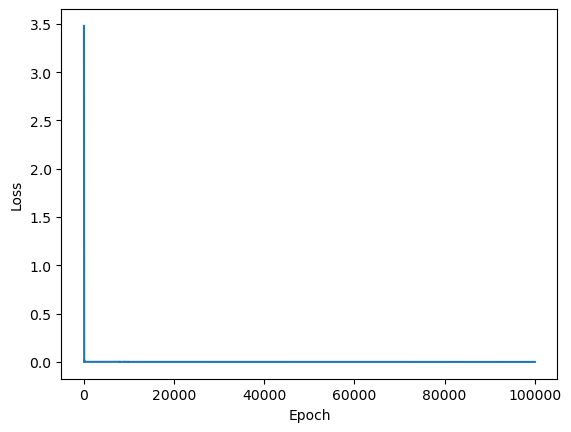

In [19]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,18,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
G = 4*np.pi**2
M=1
L=6


epochs = 100000
torch.manual_seed(413)
model = DNN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel3 = model
bestLoss3 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[0])
    loss1 = torch.mean((u_pred - u_data[0])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-1)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss3:
        bestLoss3 = loss.item()
        bestModel3 = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data[:1],u_data[:1],u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn3.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

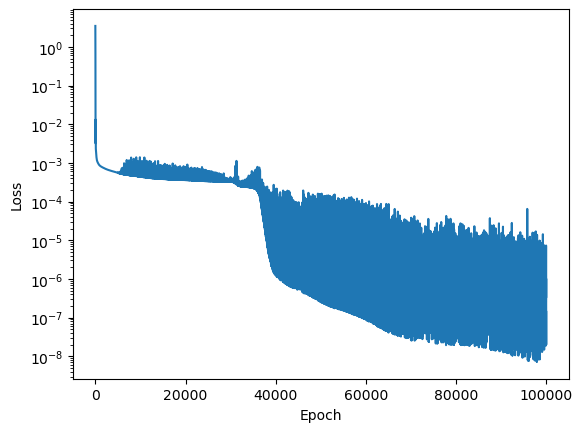

In [20]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

Best loss:  7.154536518783061e-09


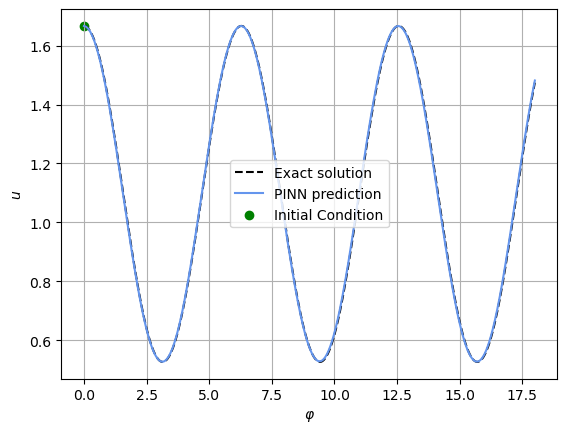

In [22]:
print('Best loss: ', bestLoss3)

# Plot the final result
u_pred = bestModel3(phi).detach()
plt.figure()
plt.plot(phi, u, 'k--', label="Exact solution")
plt.plot(phi, u_pred, color='cornflowerblue', label="PINN prediction")
plt.scatter(phi_data[0], u_data[0], color="green", label="Initial Condition")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


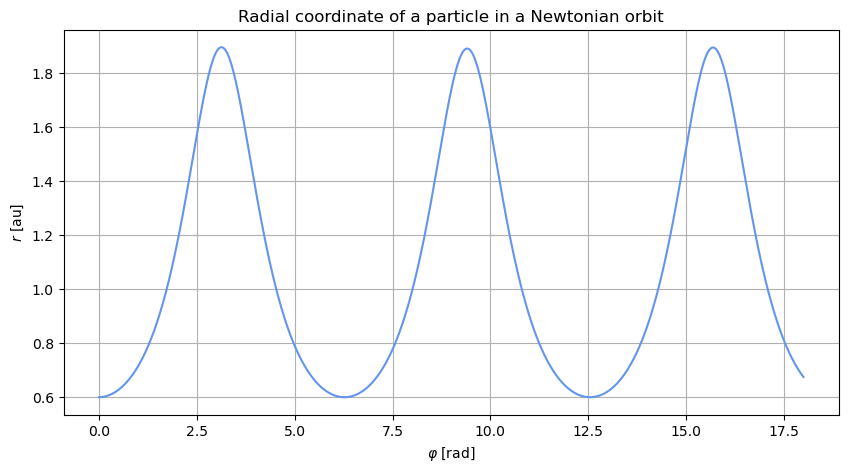

In [28]:
solr =1/u_pred
plt.figure(figsize=(10,5))
plt.plot(phi, solr, color='cornflowerblue')
plt.xlabel(r'$\varphi$ [rad]')
plt.ylabel(r'$r$ [au]')
plt.title(r'Radial coordinate of a particle in a Newtonian orbit')
plt.grid()
plt.show()

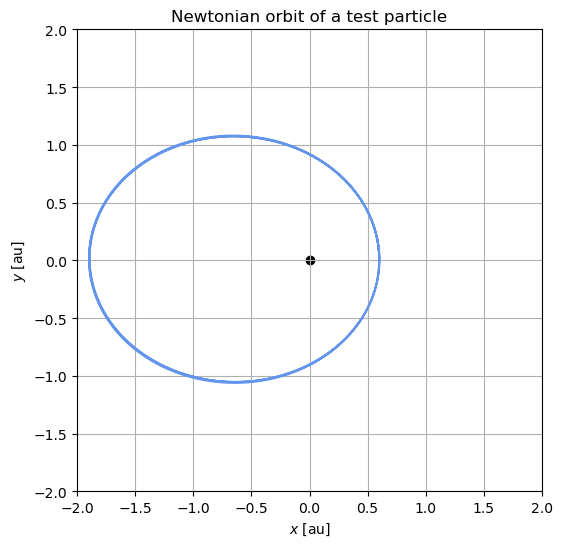

In [30]:
#Cartesian Coodinates Solution

solx = solr*np.cos(phi)
soly = solr*np.sin(phi)

plt.figure(figsize=(6,6))
plt.scatter(0,0, color='black')
plt.plot(solx, soly, color='cornflowerblue')
plt.xlabel(r'$x$ [au]')
plt.ylabel(r'$y$ [au]')
plt.title(r'Newtonian orbit of a test particle')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.show()